# Merge HIFLD licensed bed count data to HCRIS staffed ICU bed count data

## Overview

This notebook complete the following tasks:

- download HIFLD licensed bed count data
- spatially join the above data (with 150 meters buffer) with HCRIS data (which has facility level staffed ICU bed count)
- deduplicate the joined result by checking address similarity and facility name similarity
- populate the non-matching records' licensed bed count by the estimated state average ratio of staffed ICU bed count to licensed bed count
- remove redundant fields and prefix fields from HIFLD data with `hifld_`
- export the merged and cleaned result to a `.geojson` file containing all 6661 facilities originally from HCRIS data

## Download HIFLD data

#### The downloaded data are in `../data/hifld-hospitals.csv`

In [1]:
hifld_file_path = '../data/hifld-hospitals.csv'

In [2]:
!wget https://opendata.arcgis.com/datasets/6ac5e325468c4cb9b905f1728d6fbf0f_0.csv -O {hifld_file_path}

--2020-03-18 20:48:32--  https://opendata.arcgis.com/datasets/6ac5e325468c4cb9b905f1728d6fbf0f_0.csv
Resolving opendata.arcgis.com (opendata.arcgis.com)... 52.200.102.229, 3.220.181.176
Connecting to opendata.arcgis.com (opendata.arcgis.com)|52.200.102.229|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: '../data/hifld-hospitals.csv'

../data/hifld-hospi     [   <=>              ]   3.60M  7.39MB/s    in 0.5s    

2020-03-18 20:48:35 (7.39 MB/s) - '../data/hifld-hospitals.csv' saved [3771444]



## Observe HIFLD data and create a GeoDataFrame

In [3]:
import pandas as pd
import numpy as np
import geopandas as gpd

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [5]:
hifld_df = pd.read_csv(hifld_file_path, encoding='utf-8')

In [6]:
hifld_df.head()

,X,Y,OBJECTID,ID,NAME,ADDRESS,CITY,STATE,ZIP,ZIP4,TELEPHONE,TYPE,STATUS,POPULATION,COUNTY,COUNTYFIPS,COUNTRY,LATITUDE,LONGITUDE,NAICS_CODE,NAICS_DESC,SOURCE,SOURCEDATE,VAL_METHOD,VAL_DATE,WEBSITE,STATE_ID,ALT_NAME,ST_FIPS,OWNER,TTL_STAFF,BEDS,TRAUMA,HELIPAD
0,-80.069978,32.975799,7001,3829406,HEALTHSOUTH REHABILITATION HOSPITAL OF CHARLESTON,9181 MEDCOM ST,NORTH CHARLESTON,SC,29406,NOT AVAILABLE,(843) 820-7762,REHABILITATION,OPEN,46,CHARLESTON,45019,USA,32.975799,-80.069978,622310,"REHABILITATION HOSPITALS (EXCEPT ALCOHOLISM, D...",http://www.scdhec.gov/Health/FHPF/HealthFacili...,2018-08-10T00:00:00.000Z,IMAGERY/OTHER,2013-10-03T00:00:00.000Z,http://www.healthsouthcharleston.com,38784738,NOT AVAILABLE,45,PROPRIETARY,-999,46,NOT AVAILABLE,N
1,-81.942460,34.989657,7002,11029303,SPARTANBURG REHABILITATION INSTITUTE,160 HAROLD FLEMING CT,SPARTANBURG,SC,29303,4226,(864) 594-9600,REHABILITATION,OPEN,40,SPARTANBURG,45083,USA,34.989657,-81.942460,622310,"REHABILITATION HOSPITALS (EXCEPT ALCOHOLISM, D...",http://www.scdhec.gov/Health/FHPF/HealthFacili...,2018-08-10T00:00:00.000Z,IMAGERY,2016-10-27T00:00:00.000Z,http://sri.ernesthealth.com/,NOT AVAILABLE,NOT AVAILABLE,45,PROPRIETARY,-999,40,NOT AVAILABLE,N
2,-79.753122,34.161420,7003,2929505,WOMEN'S CENTER OF CAROLINAS HOSPITAL SYSTEM,1590 FREEDOM BLVD,FLORENCE,SC,29505,NOT AVAILABLE,(843) 674-2500,WOMEN,OPEN,20,FLORENCE,45041,USA,34.161420,-79.753122,622310,MATERNITY HOSPITALS,http://www.scdhec.gov/Health/FHPF/HealthFacili...,2018-08-10T00:00:00.000Z,IMAGERY/OTHER,2014-03-12T00:00:00.000Z,http://www.carolinashospital.com,38784564,NOT AVAILABLE,45,PROPRIETARY,-999,20,NOT AVAILABLE,Y
3,-120.009613,47.844970,7004,1298816,LAKE CHELAN COMMUNITY HOSPITAL,503 HIGHLAND AVE E,CHELAN,WA,98816,NOT AVAILABLE,(509) 682-2531,CRITICAL ACCESS,OPEN,25,CHELAN,53007,USA,47.844970,-120.009613,622110,GENERAL MEDICAL AND SURGICAL HOSPITALS,https://fortress.wa.gov/doh/facilitysearch/Def...,2018-08-10T00:00:00.000Z,IMAGERY,2014-02-10T00:00:00.000Z,lakechelancommunityhospital.com,165,OKANOGAN-DOUGLAS DISTRICT HOSPITAL,53,GOVERNMENT - DISTRICT/AUTHORITY,-999,25,LEVEL IV,N
4,-79.440955,37.778517,7005,324450,CARILION STONEWALL JACKSON HOSPITAL,1 HEALTH CIRCLE,LEXINGTON,VA,24450,NOT AVAILABLE,(540) 458-3300,CRITICAL ACCESS,OPEN,25,LEXINGTON,51678,USA,37.778517,-79.440955,622110,GENERAL MEDICAL AND SURGICAL HOSPITALS,http://www.vhi.org,2018-08-09T00:00:00.000Z,IMAGERY/OTHER,2014-02-10T00:00:00.000Z,http://www.carilionclinic.org/Carilion/csjh,NOT AVAILABLE,NOT AVAILABLE,51,NON-PROFIT,-999,25,NOT AVAILABLE,Y


#### Append `hifld_` to all column names to identify datasource

In [7]:
hifld_df = hifld_df.add_prefix('hifld_')

In [8]:
hifld_df.head()

,hifld_X,hifld_Y,hifld_OBJECTID,hifld_ID,hifld_NAME,hifld_ADDRESS,hifld_CITY,hifld_STATE,hifld_ZIP,hifld_ZIP4,hifld_TELEPHONE,hifld_TYPE,hifld_STATUS,hifld_POPULATION,hifld_COUNTY,hifld_COUNTYFIPS,hifld_COUNTRY,hifld_LATITUDE,hifld_LONGITUDE,hifld_NAICS_CODE,hifld_NAICS_DESC,hifld_SOURCE,hifld_SOURCEDATE,hifld_VAL_METHOD,hifld_VAL_DATE,hifld_WEBSITE,hifld_STATE_ID,hifld_ALT_NAME,hifld_ST_FIPS,hifld_OWNER,hifld_TTL_STAFF,hifld_BEDS,hifld_TRAUMA,hifld_HELIPAD
0,-80.069978,32.975799,7001,3829406,HEALTHSOUTH REHABILITATION HOSPITAL OF CHARLESTON,9181 MEDCOM ST,NORTH CHARLESTON,SC,29406,NOT AVAILABLE,(843) 820-7762,REHABILITATION,OPEN,46,CHARLESTON,45019,USA,32.975799,-80.069978,622310,"REHABILITATION HOSPITALS (EXCEPT ALCOHOLISM, D...",http://www.scdhec.gov/Health/FHPF/HealthFacili...,2018-08-10T00:00:00.000Z,IMAGERY/OTHER,2013-10-03T00:00:00.000Z,http://www.healthsouthcharleston.com,38784738,NOT AVAILABLE,45,PROPRIETARY,-999,46,NOT AVAILABLE,N
1,-81.942460,34.989657,7002,11029303,SPARTANBURG REHABILITATION INSTITUTE,160 HAROLD FLEMING CT,SPARTANBURG,SC,29303,4226,(864) 594-9600,REHABILITATION,OPEN,40,SPARTANBURG,45083,USA,34.989657,-81.942460,622310,"REHABILITATION HOSPITALS (EXCEPT ALCOHOLISM, D...",http://www.scdhec.gov/Health/FHPF/HealthFacili...,2018-08-10T00:00:00.000Z,IMAGERY,2016-10-27T00:00:00.000Z,http://sri.ernesthealth.com/,NOT AVAILABLE,NOT AVAILABLE,45,PROPRIETARY,-999,40,NOT AVAILABLE,N
2,-79.753122,34.161420,7003,2929505,WOMEN'S CENTER OF CAROLINAS HOSPITAL SYSTEM,1590 FREEDOM BLVD,FLORENCE,SC,29505,NOT AVAILABLE,(843) 674-2500,WOMEN,OPEN,20,FLORENCE,45041,USA,34.161420,-79.753122,622310,MATERNITY HOSPITALS,http://www.scdhec.gov/Health/FHPF/HealthFacili...,2018-08-10T00:00:00.000Z,IMAGERY/OTHER,2014-03-12T00:00:00.000Z,http://www.carolinashospital.com,38784564,NOT AVAILABLE,45,PROPRIETARY,-999,20,NOT AVAILABLE,Y
3,-120.009613,47.844970,7004,1298816,LAKE CHELAN COMMUNITY HOSPITAL,503 HIGHLAND AVE E,CHELAN,WA,98816,NOT AVAILABLE,(509) 682-2531,CRITICAL ACCESS,OPEN,25,CHELAN,53007,USA,47.844970,-120.009613,622110,GENERAL MEDICAL AND SURGICAL HOSPITALS,https://fortress.wa.gov/doh/facilitysearch/Def...,2018-08-10T00:00:00.000Z,IMAGERY,2014-02-10T00:00:00.000Z,lakechelancommunityhospital.com,165,OKANOGAN-DOUGLAS DISTRICT HOSPITAL,53,GOVERNMENT - DISTRICT/AUTHORITY,-999,25,LEVEL IV,N
4,-79.440955,37.778517,7005,324450,CARILION STONEWALL JACKSON HOSPITAL,1 HEALTH CIRCLE,LEXINGTON,VA,24450,NOT AVAILABLE,(540) 458-3300,CRITICAL ACCESS,OPEN,25,LEXINGTON,51678,USA,37.778517,-79.440955,622110,GENERAL MEDICAL AND SURGICAL HOSPITALS,http://www.vhi.org,2018-08-09T00:00:00.000Z,IMAGERY/OTHER,2014-02-10T00:00:00.000Z,http://www.carilionclinic.org/Carilion/csjh,NOT AVAILABLE,NOT AVAILABLE,51,NON-PROFIT,-999,25,NOT AVAILABLE,Y


#### Create a `GeoDataFrame` from the above `DataFrame`, set the projection to `WGS84`, read locations from `hifld_X` and `hifld_Y` columns

In [9]:
hifld_gdf = gpd.GeoDataFrame(
    hifld_df,
    crs='EPSG:4326',
    geometry=gpd.points_from_xy(hifld_df.hifld_X, hifld_df.hifld_Y))

#### Reproject to Web Mecator to prepare for further spatial calculations

In [10]:
hifld_gdf = hifld_gdf.to_crs('EPSG:3857')

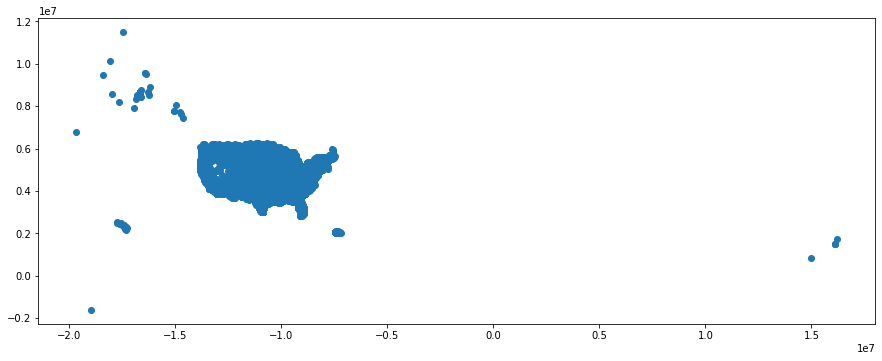

In [11]:
hifld_gdf.plot(figsize=(15, 10))

## Import HCRIS data 

In [12]:
hcris_hospital_beds_gdf = gpd.read_file('../data/usa_hospital_beds_hcris2018_cleaned3.geojson', encoding='utf-8')

In [13]:
hcris_hospital_beds_gdf.head()

,PROVIDER_NUMBER,FYB,FYE,STATUS,CTRL_TYPE,HOSP10_Name,Street_Addr,PO_Box,City,State,Zip_Code,County,Hospital Adult and Peds Beds,Intensive Care Unit Beds,Coronary Care Unit Beds,Burn ICU Beds,Surgical ICU Beds,Total Beds,Hospital Adult and Peds Bed Days Available,Intensive Care Unit Bed Days Available,Coronary Care Unit Bed Days Available,Burn ICU Bed Days Available,Surgical ICU Bed Days Available,Total Bed Days Available,Hospital Adult and Peds Inpt Days,Intensive Care Unit Inpt Days,Coronary Care Unit Inpt Days,Burn ICU Inpt Days,Surgical ICU Inpt Days,Total Inpt Days,ICU Total Beds,ICU Total Bed Days Available,ICU Total Inpt Days,ICU Occupancy Rate,Total Bed Occupancy Rate,geometry
0,010001,01-OCT-17,30-SEP-18,As Submitted,9,SOUTHEAST HEALTH MEDICAL CENTER,1108 ROSS CLARK CIRCLE,6987,DOTHAN,AL,36301,HOUSTON,271.0,40.0,0.0,0.0,0.0,327.0,98915.0,14600.0,0.0,0.0,0.0,119355.0,78031.0,11992.0,0.0,0.0,0.0,95560.0,40.0,14600.0,11992.0,0.821370,0.800637,POINT (-85.36253 31.21591)
1,010005,01-OCT-17,30-SEP-18,As Submitted,9,MARSHALL MEDICAL CENTER - SOUTH,2505 U.S. HIGHWAY 431,None,BOAZ,AL,35957-,MARSHALL,184.0,20.0,0.0,0.0,0.0,204.0,67160.0,7300.0,0.0,0.0,0.0,74460.0,30597.0,5283.0,0.0,0.0,0.0,38089.0,20.0,7300.0,5283.0,0.723699,0.511536,POINT (-86.16006 34.22140)
2,010006,01-JUL-18,30-JUN-19,As Submitted,4,NORTH ALABAMA MEDICAL CENTER,1701 VETERANS DRIVE,818,FLORENCE,AL,35630,LAUDERDALE,181.0,36.0,16.0,0.0,0.0,233.0,85802.0,10233.0,8135.0,0.0,0.0,104170.0,44822.0,5732.0,7515.0,0.0,0.0,61969.0,52.0,18368.0,13247.0,0.721200,0.594883,POINT (-87.65095 34.80439)
3,010007,01-OCT-17,30-SEP-18,As Submitted,9,MIZELL MEMORIAL HOSPITAL,702 MAIN STREET,429,OPP,AL,36462-,COVINGTON,40.0,5.0,0.0,0.0,0.0,45.0,14600.0,1825.0,0.0,0.0,0.0,16425.0,3300.0,1126.0,0.0,0.0,0.0,4571.0,5.0,1825.0,1126.0,0.616986,0.278295,POINT (-86.25417 31.29198)
4,010008,01-JAN-18,31-DEC-18,As Submitted,4,CRENSHAW COMMUNITY HOSPITAL,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,29.0,0.0,0.0,0.0,0.0,29.0,10585.0,0.0,0.0,0.0,0.0,10585.0,1323.0,0.0,0.0,0.0,0.0,1334.0,0.0,0.0,0.0,NaN,0.126027,POINT (-86.26472 31.69361)


#### There may not be one-to-one matches
There are 6,661 facilities in HCRIS data, and 7,581 facilities in HIFLD data. Even if there are more entries in the latter, we cannot guarantee that all 6,661 records from the former will have matches as a result of spatial join.

In [14]:
print("hcris_hospital_beds_gdf", len(hcris_hospital_beds_gdf))
print("hifld_gdf", len(hifld_gdf))

hcris_hospital_beds_gdf 6661
hifld_gdf 7581


#### Reproject to Web Mecator to prepare for further spatial calculations

In [15]:
hcris_hospital_beds_gdf = hcris_hospital_beds_gdf.to_crs('EPSG:3857')

Create 150-meter (Web Mecator's unit is meter) buffer for all points in HCRIS facilities

In [16]:
hcris_hospital_beds_gdf['geom_buffered'] = hcris_hospital_beds_gdf.geometry.buffer(150)

#### Create a copy of the data and add an ID column, which will be used later on when deduplicating.

In [74]:
hcris_hospital_beds_gdf_copy = hcris_hospital_beds_gdf.copy()

In [18]:
hcris_hospital_beds_gdf_copy.insert(0, 'ID', range(0, len(hcris_hospital_beds_gdf_copy)))

#### Save the current point geometries to a `point_geometry` column, and set each record's geometry as the buffered polygon from `geom_buffered` field

In [19]:
hcris_hospital_beds_gdf_copy['point_geometry'] = hcris_hospital_beds_gdf_copy.geometry

In [20]:
hcris_hospital_beds_gdf_copy['geometry'] = hcris_hospital_beds_gdf_copy['geom_buffered']

In [21]:
hcris_hospital_beds_gdf_copy = hcris_hospital_beds_gdf_copy.set_geometry('geometry')

## Join data spatially

#### Perform spatial join to merge the HIFLD data (points) to the HCRIS data (buffered polygons)

In [22]:
joined = gpd.sjoin(hcris_hospital_beds_gdf_copy, hifld_gdf, how='left', op='intersects')

#### There are duplicates after join
The result has 7,119 entries, which contains duplicates, since the HCRIS data only has 6,661 recorded facilities.

In [23]:
len(joined)

7119

For exmaple, the first record in HCRIS has duplicated joined results

In [24]:
joined.loc[0, :]

,ID,PROVIDER_NUMBER,FYB,FYE,STATUS,CTRL_TYPE,HOSP10_Name,Street_Addr,PO_Box,City,State,Zip_Code,County,Hospital Adult and Peds Beds,Intensive Care Unit Beds,Coronary Care Unit Beds,Burn ICU Beds,Surgical ICU Beds,Total Beds,Hospital Adult and Peds Bed Days Available,Intensive Care Unit Bed Days Available,Coronary Care Unit Bed Days Available,Burn ICU Bed Days Available,Surgical ICU Bed Days Available,Total Bed Days Available,Hospital Adult and Peds Inpt Days,Intensive Care Unit Inpt Days,Coronary Care Unit Inpt Days,Burn ICU Inpt Days,Surgical ICU Inpt Days,Total Inpt Days,ICU Total Beds,ICU Total Bed Days Available,ICU Total Inpt Days,ICU Occupancy Rate,Total Bed Occupancy Rate,geometry,geom_buffered,point_geometry,index_right,hifld_X,hifld_Y,hifld_OBJECTID,hifld_ID,hifld_NAME,hifld_ADDRESS,hifld_CITY,hifld_STATE,hifld_ZIP,hifld_ZIP4,hifld_TELEPHONE,hifld_TYPE,hifld_STATUS,hifld_POPULATION,hifld_COUNTY,hifld_COUNTYFIPS,hifld_COUNTRY,hifld_LATITUDE,hifld_LONGITUDE,hifld_NAICS_CODE,hifld_NAICS_DESC,hifld_SOURCE,hifld_SOURCEDATE,hifld_VAL_METHOD,hifld_VAL_DATE,hifld_WEBSITE,hifld_STATE_ID,hifld_ALT_NAME,hifld_ST_FIPS,hifld_OWNER,hifld_TTL_STAFF,hifld_BEDS,hifld_TRAUMA,hifld_HELIPAD
0,0,010001,01-OCT-17,30-SEP-18,As Submitted,9,SOUTHEAST HEALTH MEDICAL CENTER,1108 ROSS CLARK CIRCLE,6987,DOTHAN,AL,36301,HOUSTON,271.0,40.0,0.0,0.0,0.0,327.0,98915.0,14600.0,0.0,0.0,0.0,119355.0,78031.0,11992.0,0.0,0.0,0.0,95560.0,40.0,14600.0,11992.0,0.82137,0.800637,"POLYGON ((-9502363.228 3660821.247, -9502363.9...","POLYGON ((-9502363.228 3660821.247, -9502363.9...",POINT (-9502513.228 3660821.247),2817.0,-85.362944,31.216289,4237.0,91336302.0,"NOLAND HOSPITAL DOTHAN, LLC","1108 ROSS CLARK CIRCLE, 4TH FLOOR",DOTHAN,AL,36302.0,NOT AVAILABLE,(334) 699-4300,LONG TERM CARE,OPEN,38.0,HOUSTON,01069,USA,31.216289,-85.362944,622310.0,SPECIALTY (EXCEPT PSYCHIATRIC AND SUBSTANCE AB...,http://dph1.adph.state.al.us/FacilitiesDirectory,2018-08-09T00:00:00.000Z,IMAGERY/OTHER,2015-02-03T00:00:00.000Z,NOT AVAILABLE,H3506,NOT AVAILABLE,1.0,PROPRIETARY,-999.0,38.0,NOT AVAILABLE,Y
0,0,010001,01-OCT-17,30-SEP-18,As Submitted,9,SOUTHEAST HEALTH MEDICAL CENTER,1108 ROSS CLARK CIRCLE,6987,DOTHAN,AL,36301,HOUSTON,271.0,40.0,0.0,0.0,0.0,327.0,98915.0,14600.0,0.0,0.0,0.0,119355.0,78031.0,11992.0,0.0,0.0,0.0,95560.0,40.0,14600.0,11992.0,0.82137,0.800637,"POLYGON ((-9502363.228 3660821.247, -9502363.9...","POLYGON ((-9502363.228 3660821.247, -9502363.9...",POINT (-9502513.228 3660821.247),1495.0,-85.363631,31.216304,915.0,11036301.0,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301.0,NOT AVAILABLE,(334) 793-8701,GENERAL ACUTE CARE,OPEN,420.0,HOUSTON,01069,USA,31.216304,-85.363631,622110.0,GENERAL MEDICAL AND SURGICAL HOSPITALS,http://dph1.adph.state.al.us/FacilitiesDirectory,2018-08-09T00:00:00.000Z,IMAGERY/OTHER,2014-02-10T00:00:00.000Z,http://www.samc.org,H3502,NOT AVAILABLE,1.0,GOVERNMENT - DISTRICT/AUTHORITY,-999.0,420.0,LEVEL II,Y


In [26]:
joined = joined.set_geometry('geometry')

## Deduplicate joined data

#### Calculate address and name similarity
A way to deduplicate the joined result is to compare address and name similarities between HCRIS and HIFLD on top of the spatial join.

In [28]:
from difflib import SequenceMatcher
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

In [29]:
joined['name_similarity'] = joined.apply(lambda row: similar(str(row['HOSP10_Name']), str(row['hifld_NAME'])), axis = 1) 

In [30]:
joined['address_similarity'] = joined.apply(lambda row: similar(str(row['Street_Addr']), str(row['hifld_ADDRESS'])), axis = 1) 

#### Records without null data from hifld (6210)

In [33]:
joined_no_null = joined[joined['index_right'].notnull()]
len(joined_no_null)

6210

#### Records with null data from hifld (909). These records' licensed bed counts will be estimated by state average.

In [34]:
joined_null = joined[joined['index_right'].isnull()]
len(joined_null)

909

#### Among the 6210 records without null data from hifld, there are 893 duplicates from hcris due to the spatial join

In [35]:
def getDupeRecords(df, field):
    ids = df[field]
    return df[ids.isin(ids[ids.duplicated()])]

In [36]:
joined_no_null_dupe = getDupeRecords(joined_no_null, "ID")
len(joined_no_null_dupe)

893

#### 5,317 records are unique ones that we will use directly in the end

In [37]:
ids_no_null = joined_no_null['ID']
joined_no_null_no_dupe = joined_no_null[~ids_no_null.isin(ids_no_null[ids_no_null.duplicated()])]
len(joined_no_null_no_dupe)

5317

#### First, among 893 duplicates, find and keep the records with higher address matching score

In [38]:
address_similarity_maxes = joined_no_null_dupe.groupby(['ID']).address_similarity.transform(max)
joined_no_null_dedupe_address = joined_no_null_dupe[(joined_no_null_dupe.address_similarity == address_similarity_maxes)]
len(joined_no_null_dedupe_address)

527

#### Then, among the above result, find and keep the records with higher naming matching score

In [39]:
name_similarity_maxes = joined_no_null_dedupe_address.groupby(['ID']).name_similarity.transform(max)
joined_no_null_dedupe_address_name = joined_no_null_dedupe_address[(joined_no_null_dedupe_address.name_similarity == name_similarity_maxes)]
len(joined_no_null_dedupe_address_name)

435

In [40]:
joined_no_null_deduped = joined_no_null_no_dupe.append(joined_no_null_dedupe_address_name)

#### For each facility calculate staffed ICU bed to licenses bed ratio to prepare for estimation of the non-matching records

In [42]:
joined_no_null_deduped['icu_to_licensed'] = joined_no_null_deduped['ICU Total Beds'] / joined_no_null_deduped['hifld_BEDS']

## Fill in non-matching data with estimates

#### Mark records with `hifld_BEDS` info from spatial join as "not by estimation flag"

In [44]:
joined_no_null_deduped['is_hifld_BEDS_estimated'] = 0

In [45]:
len(joined_no_null_deduped)

5752

#### Calculate average ratio of staffed ICU bed to licensed bed by state

In [47]:
icu_to_licensed_state_avg = joined_no_null_deduped.groupby(['State'])['icu_to_licensed'].mean().reset_index()

#### Join the state average ratio with the data frame of those non-matching records and calculate estimates

In [48]:
joined_null_with_ratio = joined_null.merge(icu_to_licensed_state_avg, on='State')

In [52]:
joined_null_with_ratio['hifld_BEDS'] = joined_null_with_ratio['ICU Total Beds']/joined_null_with_ratio['icu_to_licensed']

In [53]:
joined_null_with_ratio['hifld_BEDS'] = joined_null_with_ratio['hifld_BEDS'].astype(int)

#### Mark these records with `hifld_BEDS` info from spatial join as "by estimation flag"

In [54]:
joined_null_with_ratio['is_hifld_BEDS_estimated'] = 1

#### There are some records with no state average data

The resulting `hifld_BEDS` is `null`, mark them as "not from real count and not from estimation"

In [75]:
not_joined_with_null = joined_null[~joined_null.ID.isin(list(joined_null_with_ratio['ID']))].copy()

In [56]:
not_joined_with_null['is_hifld_BEDS_estimated'] = 9

#### Merge the deduplicated records, records resulted from estimations, and records without any licensed bed count info

In [57]:
result = joined_no_null_deduped.append(joined_null_with_ratio).append(not_joined_with_null)

In [58]:
result = result.sort_values(by=['ID'])

In [59]:
result = result.to_crs('EPSG:4326')

In [60]:
result['geom_buffered'] = result['geometry']

In [61]:
result = result.to_crs('EPSG:3857')

In [62]:
result['geometry'] = result['point_geometry']

In [63]:
result = result.set_geometry('geometry')

In [64]:
result = result.to_crs('EPSG:4326')

In [65]:
result['point_geometry'] = result['geometry']

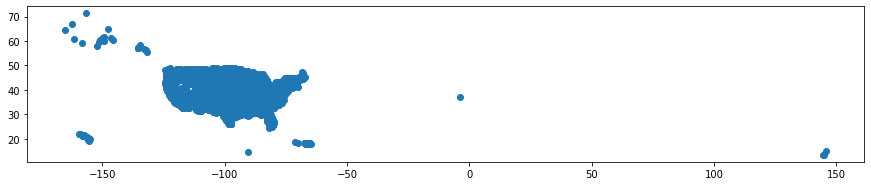

In [66]:
result.plot(figsize=(15, 10))

## Clean data up and export as GeoJSON

#### Remove unwanted columns

In [69]:
result.drop(['point_geometry', 'hifld_X', 'hifld_Y', 'geom_buffered'], axis=1, inplace=True)

#### Make sure the schema can be parsed (by Fiona internally)

In [70]:
gpd.io.file.infer_schema(result)

{'geometry': 'Point',
 'properties': OrderedDict([('ID', 'int'),
              ('PROVIDER_NUMBER', 'str'),
              ('FYB', 'str'),
              ('FYE', 'str'),
              ('STATUS', 'str'),
              ('CTRL_TYPE', 'int'),
              ('HOSP10_Name', 'str'),
              ('Street_Addr', 'str'),
              ('PO_Box', 'str'),
              ('City', 'str'),
              ('State', 'str'),
              ('Zip_Code', 'str'),
              ('County', 'str'),
              ('Hospital Adult and Peds Beds', 'float'),
              ('Intensive Care Unit Beds', 'float'),
              ('Coronary Care Unit Beds', 'float'),
              ('Burn ICU Beds', 'float'),
              ('Surgical ICU Beds', 'float'),
              ('Total Beds', 'float'),
              ('Hospital Adult and Peds Bed Days Available', 'float'),
              ('Intensive Care Unit Bed Days Available', 'float'),
              ('Coronary Care Unit Bed Days Available', 'float'),
              ('Burn ICU Bed Da

#### Export data to `../data/usa_hospital_beds_hcris2018_merge_hifld.geojson`

In [73]:
result.to_file('../data/usa_hospital_beds_hcris2018_merge_hifld.geojson', encoding='utf-8', driver='GeoJSON')